In [1]:
import tensorflow as tf
import os

Load Data

In [2]:
import numpy as numpy
from matplotlib import pyplot as plt


In [3]:
import cv2
import imghdr

C:\Users\Biswaji Deb\AppData\Local\Temp\ipykernel_8540\4232469594.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [4]:
data_dir = 'Affectnet Dataset'

In [5]:
os.listdir(data_dir)

['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [6]:
os.listdir(os.path.join(data_dir,'anger'))

['Anger_Split.txt',
 'image0000006.jpg',
 'image0000060.jpg',
 'image0000061.jpg',
 'image0000066.jpg',
 'image0000106.jpg',
 'image0000132.jpg',
 'image0000138.jpg',
 'image0000182.jpg',
 'image0000195.jpg',
 'image0000213.jpg',
 'image0000228.jpg',
 'image0000294.jpg',
 'image0000333.jpg',
 'image0000343.jpg',
 'image0000346.jpg',
 'image0000356.jpg',
 'image0000368.jpg',
 'image0000374.jpg',
 'image0000390.jpg',
 'image0000399.jpg',
 'image0000407.jpg',
 'image0000415.jpg',
 'image0000416.jpg',
 'image0000441.jpg',
 'image0000450.jpg',
 'image0000470.jpg',
 'image0000511.jpg',
 'image0000513.jpg',
 'image0000593.jpg',
 'image0000602.jpg',
 'image0000690.jpg',
 'image0000697.jpg',
 'image0000722.jpg',
 'image0000723.jpg',
 'image0000758.jpg',
 'image0000776.jpg',
 'image0000825.jpg',
 'image0000908.jpg',
 'image0000923.jpg',
 'image0000932.jpg',
 'image0000949.jpg',
 'image0000963.jpg',
 'image0000965.jpg',
 'image0000972.jpg',
 'image0000996.jpg',
 'image0001015.jpg',
 'image0001021

In [25]:
#tf.keras.utils.image_dataset_from_directory??

In [25]:
#Builiding data pipeline
data = tf.keras.utils.image_dataset_from_directory('Affectnet Dataset',labels='inferred',color_mode='rgb',batch_size=32,shuffle='True')
#still not a dataset, instead it's a generator

Found 29042 files belonging to 8 classes.


In [27]:
#Allows to loop through data pipeline
data_iterator = data.as_numpy_iterator()
data_iterator

In [28]:
batch = data_iterator.next()
#images represented as np arrays in batches of size 32
batch[0].shape

(32, 256, 256, 3)

In [29]:
#Images classified from 0-7
batch[1]

array([3, 5, 4, 2, 5, 6, 2, 7, 5, 4, 4, 0, 0, 5, 5, 2, 0, 4, 6, 7, 3, 3,
       3, 1, 7, 3, 4, 6, 3, 6, 4, 2])

In [30]:
len(batch)
#2 = images,it's labels

2

Anger = 0
Contempt = 1
disgust = 2
fear = 3
happy = 4
neutral = 5
sad = 6
Surprise = 7

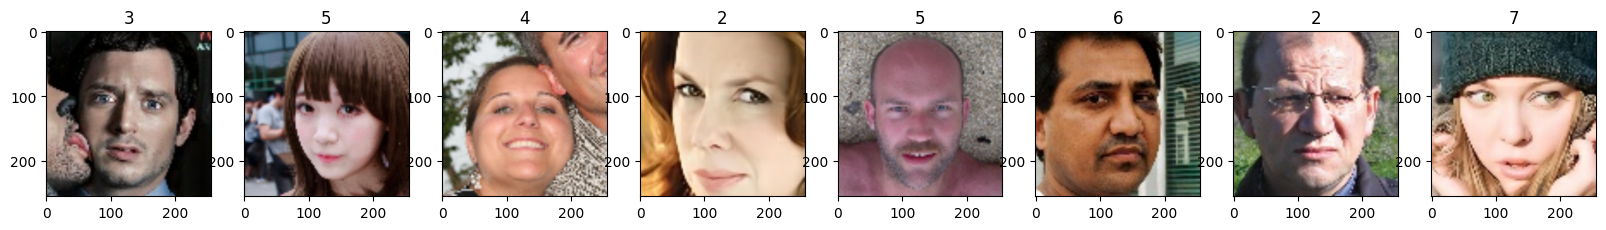

In [31]:
#To check the batch
fig, ax = plt.subplots(ncols=8, figsize=(20,20))
for idx, img in enumerate(batch[0][:8]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [32]:
batch = data_iterator.next()
batch[1]
#Images = batch[0] #Labels = bath[1]

array([7, 6, 6, 1, 3, 0, 4, 0, 3, 3, 6, 4, 6, 6, 3, 6, 7, 2, 6, 7, 0, 5,
       1, 5, 0, 5, 6, 2, 2, 7, 7, 1])

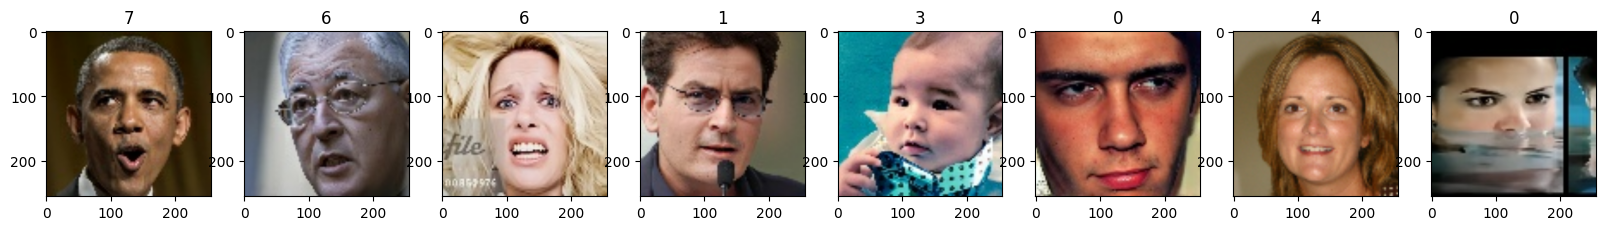

In [33]:
fig, ax = plt.subplots(ncols=8, figsize=(20,20))
for idx, img in enumerate(batch[0][:8]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

Preprocessing Data (Scaling,spliting between train,test)

In [34]:
print(batch[0].min())
print(batch[0].max())

0.0
255.0


In [35]:
scaled = batch[0]/255
print(scaled[0].min())
print(scaled[0].max())

0.0
0.98573834


Scaling all the data at one time while loading from pipeline instead of doing it in batches

In [36]:
data=data.map(lambda x,y:(x/255,y))

In [37]:
data.as_numpy_iterator().next()

(array([[[[0.45882353, 0.52156866, 0.34509805],
          [0.4617647 , 0.5242647 , 0.3482843 ],
          [0.47941175, 0.54044116, 0.36740196],
          ...,
          [0.5686275 , 0.56078434, 0.50539213],
          [0.5921569 , 0.58431375, 0.5259804 ],
          [0.59607846, 0.5882353 , 0.5294118 ]],
 
         [[0.46053922, 0.5230392 , 0.34705883],
          [0.46329656, 0.5255668 , 0.35004595],
          [0.4798407 , 0.5407322 , 0.36796874],
          ...,
          [0.5673866 , 0.5595435 , 0.50415134],
          [0.59008884, 0.5822457 , 0.5239124 ],
          [0.59387255, 0.5860294 , 0.5272059 ]],
 
         [[0.47083333, 0.53186274, 0.35882354],
          [0.47248775, 0.5333793 , 0.36061582],
          [0.48241422, 0.54247856, 0.37136948],
          ...,
          [0.55994177, 0.55209863, 0.4967065 ],
          [0.57768077, 0.5698376 , 0.5115043 ],
          [0.5806373 , 0.57279414, 0.5139706 ]],
 
         ...,
 
         [[0.37745097, 0.5125    , 0.40245098],
          [0.35902

Spliting Test train 


In [38]:
#Total 908 batches and 32 images each ie; 32*908 = 29056
len(data)

908

In [39]:
traing_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

print(traing_size)
print(val_size)
print(test_size)
print(traing_size+val_size+test_size)

635
182
91
908


Take and skip method within tensorflow to split 

In [40]:
train=data.take(traing_size)
val=data.take(traing_size).take(val_size)
test = data.skip(traing_size+val_size).take(test_size)

In [41]:
len(test)

91

Creating CNN model

Building Deep learning model


In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [ ]:
#MaxPooling2D??

In [54]:
model = Sequential()

model.add(Conv2D(64, (3,3), 1, activation='relu', input_shape=(256,256,3)))#Convolution layer 1
model.add(MaxPooling2D())#Pooling layer 1

model.add(Conv2D(32, (3,3), 1, activation='relu'))#Convolution layer 2
model.add(MaxPooling2D())#Pooling layer 2

model.add(Conv2D(16, (3,3), 1, activation='relu'))#Convolution layer 3
model.add(MaxPooling2D())#Pooling layer 3

model.add(Flatten())#Fully Connected layer

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='softmax'))#Output layer

In [57]:
model.compile('sgd', loss=tf.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [58]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 127, 127, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 32)      18464     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 30, 30, 16)       

Visualize CNN model

In [59]:
import visualkeras
visualkeras.layered_view(model).show() # display using your system viewer
visualkeras.layered_view(model, to_file='Neural_Network_Visualize.png') # write to disk
visualkeras.layered_view(model, to_file='Neural_Network_Visualize.png').show() # write and show

Train

In [60]:
logdir='logs'

In [61]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [62]:
Log_history = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


C:\Users\Biswaji Deb\AppData\Roaming\Python\Python311\site-packages\tensorflow\python\util\dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


635/635 [==============================] - 803s 1s/step - loss: nan - accuracy: 0.1106 - val_loss: nan - val_accuracy: 0.1056
Epoch 2/20
635/635 [==============================] - 774s 1s/step - loss: nan - accuracy: 0.1104 - val_loss: nan - val_accuracy: 0.1046
Epoch 3/20
635/635 [==============================] - 1588s 3s/step - loss: nan - accuracy: 0.1104 - val_loss: nan - val_accuracy: 0.1053
Epoch 4/20
635/635 [==============================] - 779s 1s/step - loss: nan - accuracy: 0.1105 - val_loss: nan - val_accuracy: 0.1047
Epoch 5/20
635/635 [==============================] - 775s 1s/step - loss: nan - accuracy: 0.1106 - val_loss: nan - val_accuracy: 0.1046
Epoch 6/20
635/635 [==============================] - 777s 1s/step - loss: nan - accuracy: 0.1106 - val_loss: nan - val_accuracy: 0.1056
Epoch 7/20
635/635 [==============================] - 772s 1s/step - loss: nan - accuracy: 0.1102 - val_loss: nan - val_accuracy: 0.1047
Epoch 8/20
635/635 [==============================]

Performance

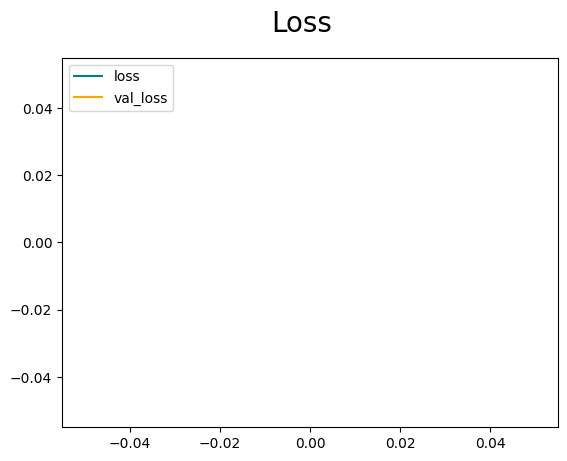

In [63]:
fig = plt.figure()
plt.plot(Log_history.history['loss'], color='teal', label='loss')
plt.plot(Log_history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

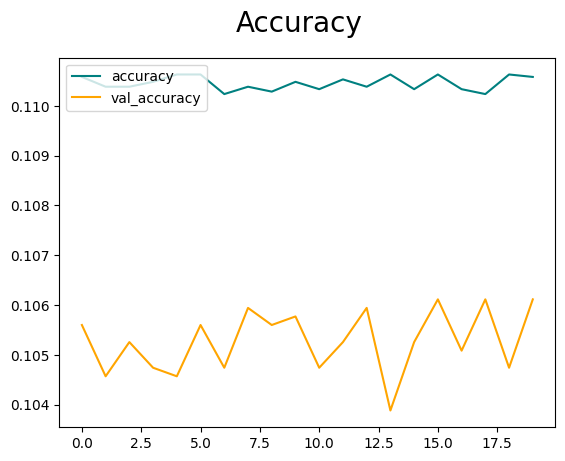

In [64]:
fig = plt.figure()
plt.plot(Log_history.history['accuracy'], color='teal', label='accuracy')
plt.plot(Log_history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

Evaluate performance

In [65]:
from tensorflow.keras.metrics import Precision, Recall,BinaryAccuracy

In [66]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [67]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 201ms/step


In [68]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy : {acc.result().numpy()}')

Precision:0.0, Recall:0.0, Accuracy : 0.11352656781673431


Test

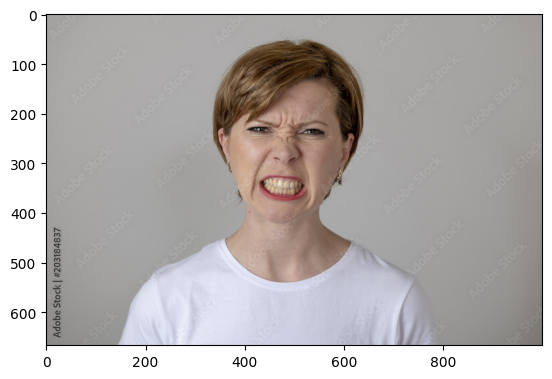

In [69]:
img = cv2.imread('test/angry2.jpg')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

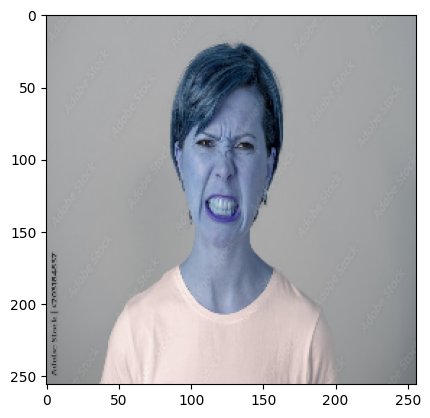

In [70]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [71]:
import numpy as np

In [72]:
resize.shape

TensorShape([256, 256, 3])

In [73]:
np.expand_dims(resize,0).shape

(1, 256, 256, 3)

In [74]:

yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 29ms/step


In [75]:

yhat

array([[nan]], dtype=float32)

In [76]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


Save the model

In [77]:
from tensorflow.keras.models import load_model

In [78]:
model.save(os.path.join('models','emotion_cnn.h5'))

C:\Users\Biswaji Deb\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [79]:
new_model = load_model(os.path.join('models','emotion_cnn.h5'))

In [80]:
new_model.predict(np.expand_dims(resize/255,0))

1/1 [==============================] - 0s 77ms/step


array([[nan]], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


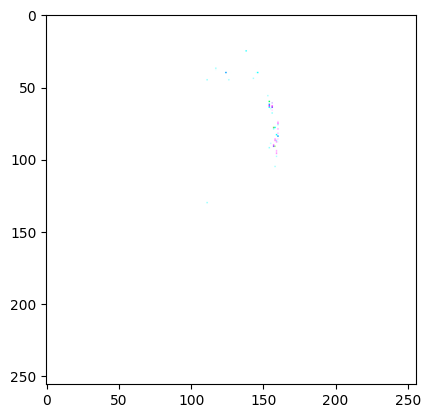

In [81]:
plt.imshow(resize)